# A simple binary problem: is there a legal move or not?

This is a simplified version in which the model only answers the question whether there is at least one legal move or not.

In [ ]:
from MorpionSolitaire import *
from DeepLearningMS import *

In [ ]:
# from multiprocess import Pool
# pool = Pool()

## Data generation

This function plays one game at random until there are no more moves, stores the grid as `grid1`, then rewinds the game to an interemediate stage, and stores the resulting grid as `grid2`. The output of the function is a tensor containing the two grids. By construction the first grid has no legal moves and the second one has at least one legal move.

1/3 of the time the game is taken back to an arbitrary intermediate step.
The other 2/3 of the time we rewind the game by only one step, so that the network gets used to identify a single allowed move. If we did not do that the training process would result in a relatively high accuracy by only identifying some types of allowed moves instead of all of them.

In [ ]:
def play_one_game(host = 0): # dummy argument needed for passing to pool.map
    game = NewGame('cross').play()
    grid1 = game.grid.image()
    if np.random.randint(3) == 0:
        game = game.unplay(np.random.randint(game.score - 1) + 2)
    else:
        game = game.unplay(1)
    grid2 = game.grid.image()
    return np.stack((grid1, grid2))

Mini-batches contains a certain number of grids obtained in the way described above (computed in parallel to gain time), as well as a labels (0 for no legal moves, 1 for at least one legal move).

In [ ]:
# def generate_batch(batch_size = 100):
#     x = torch.tensor(np.concatenate(pool.map(play_one_game, range(batch_size // 2)))).float().unsqueeze(1)
#     y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
#     return x, y

In [ ]:
def generate_batch(batch_size = 100):
    x = []
    for _ in range(batch_size // 2):
        x.append(play_one_game())
    x = torch.tensor(np.concatenate(x)).float().unsqueeze(1)
    y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
    return x, y

20,000 grids and labels computed in this way are saved once and for all:

In [ ]:
# grids = np.concatenate(pool.map(play_one_game, range(10000)))
# np.save('data/simple_problem_grids.npy', grids)
# grids.shape

In [ ]:
# labels = np.zeros(20000, dtype=bool)
# labels[1::2] = True
# np.save('data/simple_problem_labels.npy', labels)
# labels.shape

## Data frame

In [ ]:
# data = MSDataFrame(generate_batch, repeat = 1000, length = 200)
# data.info()

In [ ]:
data = MSDataFrame(batch_size = 200, length = 100,
                   data = 'data/simple_problem_grids.npy',
                   labels = 'data/simple_problem_labels.npy')
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 0


In [ ]:
x, y = data.data[0]

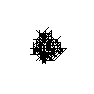

In [ ]:
MSvisualize(x[0])

In [ ]:
y[0]

tensor([0.])

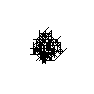

In [ ]:
MSvisualize(x[1])

In [ ]:
y[1]

tensor([1.])

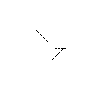

In [ ]:
MSvisualize(x[1]-x[0])

## Model

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 40, stride = 3, kernel_size = 13, padding = 0),
    torch.nn.AdaptiveMaxPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(40, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1)
)

In [ ]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [ ]:
def accuracy(outputs, labels):
    return ((outputs > 0.5) == labels).float().mean()

In [ ]:
accuracy(y_pred, y)

tensor(0.5000)

## Training

In [ ]:
running_loss_data = []
accuracy_data = []

In [ ]:
data.train_model(net, n_epochs = 100, lr=0.005, accuracy_func = accuracy,
                 loss_monitoring = running_loss_data,
                 accuracy_monitoring = accuracy_data)

/home/marc/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[0]  loss: 0.249   accuracy: 0.55
[1]  loss: 0.246   accuracy: 0.57
[2]  loss: 0.241   accuracy: 0.57
[3]  loss: 0.238   accuracy: 0.58
[4]  loss: 0.235   accuracy: 0.58
[5]  loss: 0.233   accuracy: 0.58
[6]  loss: 0.230   accuracy: 0.59
[7]  loss: 0.226   accuracy: 0.61
[8]  loss: 0.222   accuracy: 0.63
[9]  loss: 0.217   accuracy: 0.65
[10]  loss: 0.213   accuracy: 0.65
[11]  loss: 0.210   accuracy: 0.66
[12]  loss: 0.207   accuracy: 0.66
[13]  loss: 0.204   accuracy: 0.67
[14]  loss: 0.201   accuracy: 0.68
[15]  loss: 0.198   accuracy: 0.68
[16]  loss: 0.200   accuracy: 0.68
[17]  loss: 0.195   accuracy: 0.69
[18]  loss: 0.193   accuracy: 0.70
[19]  loss: 0.189   accuracy: 0.70
[20]  loss: 0.189   accuracy: 0.71
[21]  loss: 0.186   accuracy: 0.71
[22]  loss: 0.183   accuracy: 0.72
[23]  loss: 0.180   accuracy: 0.72
[24]  loss: 0.179   accuracy: 0.73
[25]  loss: 0.175   accuracy: 0.73
[26]  loss: 0.174   accuracy: 0.73
[27]  loss: 0.172   accuracy: 0.73
[28]  loss: 0.170   accuracy: 

In [ ]:
# torch.save(net, 'models/Democritus.pt')

In [ ]:
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 0


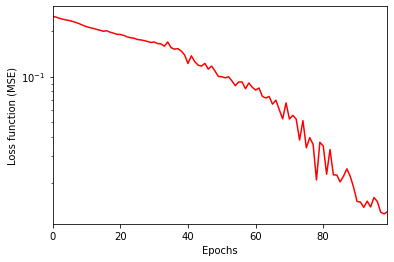

In [ ]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Epochs')
plt.xlim(0, 99)
plt.ylabel('Loss function (MSE)')
plt.yscale('log')
# plt.savefig('Democritus_loss.png', bbox_inches='tight')
plt.show()

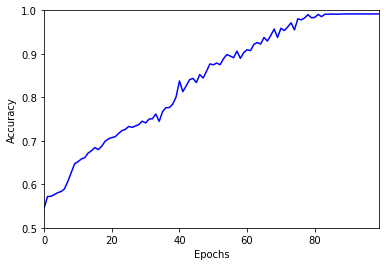

In [ ]:
plt.plot(accuracy_data, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 99)
plt.ylim(0.5, 1)
# plt.savefig('Democritus_accuracy.png', bbox_inches='tight')
plt.show()

In [ ]:
error_data = [1.0 - x for x in accuracy_data]

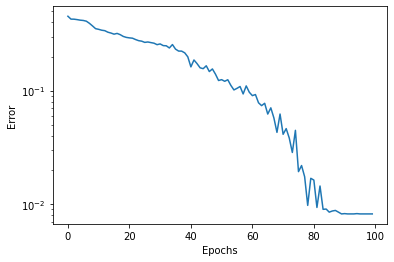

In [ ]:
plt.plot(error_data)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [ ]:
# net = torch.load('models/Democritus.pt')
# net.eval()

## Validation

In [ ]:
x, y = generate_batch(1000)

In [ ]:
y_preds = net(x).data

In [ ]:
accuracy(y_preds, y)

tensor(0.9910)

In [ ]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.5000), tensor(0.5003), tensor(0.5172), tensor(0.4768))

In [ ]:
mistakes = []
for i in range(y.shape[0]):
    if (y_preds[i] > 0.5) != y[i]:
        mistakes.append([y[i].item(), y_preds[i].item(), i])
mistakes

[[0.0, 0.9490686655044556, 82],
 [0.0, 0.9476900696754456, 284],
 [0.0, 0.9520288705825806, 302],
 [0.0, 0.942275881767273, 364],
 [0.0, 0.9486956000328064, 366],
 [0.0, 0.9575375318527222, 468],
 [0.0, 0.9449511170387268, 522],
 [0.0, 0.947419285774231, 640],
 [0.0, 0.9446878433227539, 964]]

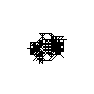

In [ ]:
MSvisualize(x[mistakes[0][2]])

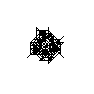

In [ ]:
MSvisualize(x[mistakes[1][2]])

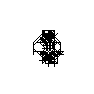

In [ ]:
MSvisualize(x[mistakes[2][2]])

## Network state

In [ ]:
params = []
for param in net.parameters():
    params.append(param.data)
    print(param.size())

torch.Size([40, 1, 13, 13])
torch.Size([40])
torch.Size([4, 40])
torch.Size([4])
torch.Size([2, 4])
torch.Size([2])
torch.Size([1, 2])
torch.Size([1])


In [ ]:
def divisors(x):
    i = np.round(np.sqrt(x)).astype(int)
    for j in range(i - 1):
        if x % (i - j) == 0:
            n = x // (i - j)
            return (n, x // n)
    return (x, 1)

In [ ]:
# par = np.array(params[0].squeeze())
# par *= -1.0
# par = par - np.min(par)
# par = par / np.max(par)
# par = np.round(255 * par)
# w, h = divisors(par.shape[0])
# im = np.zeros((15 * h, 15 * w), dtype = int)
# for i in range(h):
#     for j in range(w):
#         im[15*i+1:15*i+14,15*j+1:15*j+14] = par[w*i + j]
# image = Image.fromarray(np.uint8(im), 'L').resize((w*60, h*60), resample=0, box=None)
# image

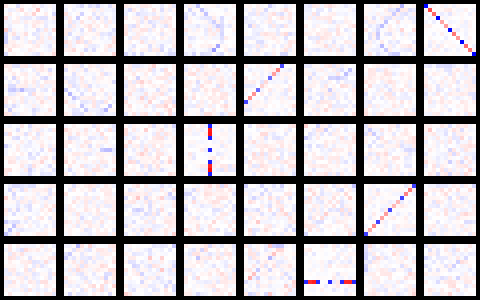

In [ ]:
par = params[0].squeeze()
par /= torch.max(torch.abs(par))
blue = torch.tensor([1,1,0]).unsqueeze(1).unsqueeze(2)
red = torch.tensor([0,1,1]).unsqueeze(1).unsqueeze(2)
par = (blue * torch.where(par > 0, par, 0.0 * par).unsqueeze(1)
       + red * torch.where(par < 0, -1.0 * par, 0.0 * par).unsqueeze(1))
par = np.round(255 * par)
par = np.array(par).astype(int)
w, h = divisors(par.shape[0])
im = np.zeros((15 * h, 15 * w, 3), dtype = int)
for i in range(h):
    for j in range(w):
        for c in range(3):
            im[15*i+1:15*i+14,15*j+1:15*j+14,c] = 255 - par[w*i + j, c]
image = Image.fromarray(np.uint8(im), 'RGB').resize((w*60, h*60), resample=0, box=None)
image

In [ ]:
# image.save('Democritus_convlayer.png')

In [ ]:
kernel = params[0][37].squeeze()

In [ ]:
segment = kernel[9]
segment

tensor([ 0.8419, -0.8200, -0.8803,  0.8365,  0.0042, -0.0134,  0.8313,  0.0803,
        -0.0823,  0.8359, -0.8455, -0.8557,  0.8421])

In [ ]:
val = segment * torch.tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
val = val.sum()
val

tensor(4.1877)

## Remarks

- The same network has been trained with dynamical data (using new grids after 8 iterations). Results are identical. This shows that the pool of data used here is sufficiently large.

- Training with smaller mini-batches means quicker learning, but often saturation at accuracies way below 99%. With batch size 50 I got up to around 90% accuracy at best, with batch size 100 up to 95-98%.

- Most of the first layer is ends up unused, but working with fewer channels does not work: either some features are missing in the end, resulting in low accuracy, or the neural net gets stuck in a state where it always returns 0.5 after the first few training steps, yielding a loss function 0.25 and accuracy 0.5. 